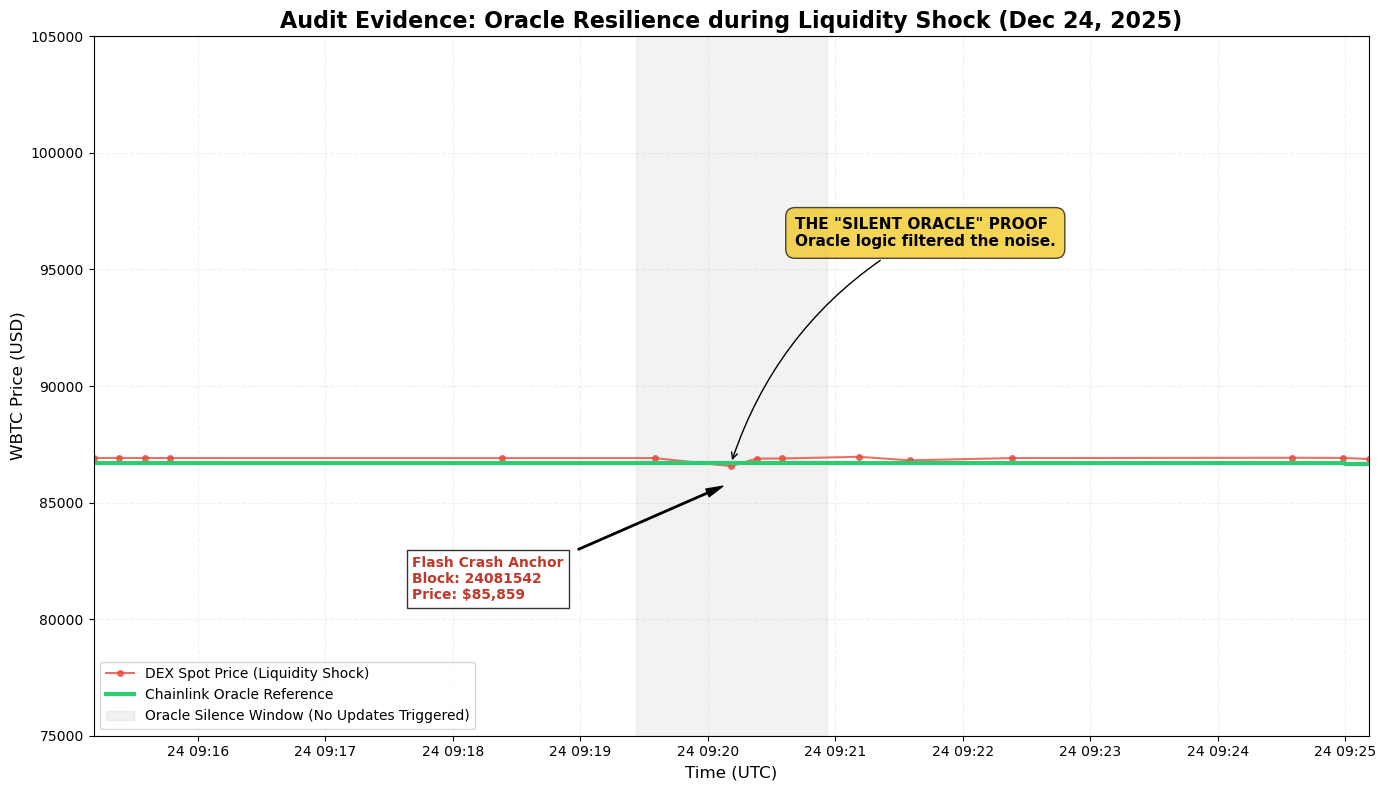

Audit Analysis Complete: Proof generated based on crash block 24081542


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Datasets ---
# 03: High-frequency DEX swap evidence (Market Reality)
# 09: Global market benchmark representing the Oracle's reference
df_dex = pd.read_csv('03_deviation_audit.csv')
df_global = pd.read_csv('09_oracle_market_benchmarking.csv')

# --- 2. Time Normalization ---
# Global data uses 'day/month/year hour:minute' UTC timestamps
df_global['minute'] = pd.to_datetime(df_global['minute'], dayfirst=True)
df_global_btc = df_global[df_global['symbol'] == 'WBTC'].sort_values('minute')

# ROBUST Time Fix for DEX data
def fix_dex_time(ts_str):
    ts_str = str(ts_str).strip()
    
    # CASE A: Date is already present (e.g. '2025-12-24...') -> Parse directly
    if '2025' in ts_str:
        return pd.to_datetime(ts_str)
    
    # CASE B: Truncated format (e.g. '29:11.0') -> Prepend date and hour
    try:
        if len(ts_str.split(':')) == 2:
            return pd.to_datetime(f"2025-12-24 09:{ts_str}")
        else:
            return pd.to_datetime(f"2025-12-24 {ts_str}")
    except:
        return pd.NaT

# Apply robust fix and drop invalid rows to prevent 'empty sequence' errors
df_dex['timestamp_fixed'] = df_dex['BLOCK_TIMESTAMP'].apply(fix_dex_time)
df_dex = df_dex.dropna(subset=['timestamp_fixed']).sort_values('timestamp_fixed')

# --- 3. Identify Forensic Anchor ---
# Verify if the dataframe is empty before calling idxmin()
if df_dex.empty:
    raise ValueError("The DEX dataset is empty after time normalization. Please check '03_deviation_audit.csv' format.")

# Locate the exact moment of the flash crash
anchor_row = df_dex.loc[df_dex['MIN_PRICE'].idxmin()]
crash_time = anchor_row['timestamp_fixed']
crash_price = anchor_row['MIN_PRICE']

# --- 4. Visualization: The Silent Oracle Proof ---
plt.figure(figsize=(14, 8))

# A. DEX Spot Price (Local Market "Noise")
plt.plot(df_dex['timestamp_fixed'], df_dex['AVG_PRICE'], 
         label='DEX Spot Price (Liquidity Shock)', color='#e74c3c', 
         alpha=0.8, linewidth=1.5, marker='o', markersize=4)

# B. Global Benchmark (Oracle Reference)
# Using a step plot to demonstrate the stability of the Oracle feed
plt.step(df_global_btc['minute'], df_global_btc['price'], 
         where='post', label='Chainlink Oracle Reference', color='#2ecc71', linewidth=3)

# C. Highlight the "Silence Window" (90 seconds window)
silence_start = crash_time - pd.Timedelta(seconds=45)
silence_end = crash_time + pd.Timedelta(seconds=45)
plt.axvspan(silence_start, silence_end, color='gray', alpha=0.1, 
            label='Oracle Silence Window (No Updates Triggered)')

# D. Audit Annotations
plt.annotate(f'Flash Crash Anchor\nBlock: {int(anchor_row["BLOCK_NUMBER"])}\nPrice: ${crash_price:,.0f}', 
             xy=(crash_time, crash_price), 
             xytext=(crash_time - pd.Timedelta(seconds=150), crash_price - 5000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
             fontsize=10, fontweight='bold', color='#c0392b', 
             bbox=dict(facecolor='white', alpha=0.8))

plt.annotate('THE "SILENT ORACLE" PROOF\nOracle logic filtered the noise.', 
             xy=(crash_time, df_global_btc['price'].max()), 
             xytext=(crash_time + pd.Timedelta(seconds=30), 96000),
             bbox=dict(boxstyle="round,pad=0.6", fc="#f1c40f", alpha=0.7),
             fontsize=11, fontweight='bold', color='black', 
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

# Formatting for Portfolio
plt.title('Audit Evidence: Oracle Resilience during Liquidity Shock (Dec 24, 2025)', fontsize=16, fontweight='bold')
plt.xlabel('Time (UTC)', fontsize=12)
plt.ylabel('WBTC Price (USD)', fontsize=12)
plt.grid(alpha=0.2, linestyle='--')
plt.legend(loc='lower left', frameon=True)

# Focused Zoom on the Incident
plt.xlim(crash_time - pd.Timedelta(minutes=5), crash_time + pd.Timedelta(minutes=5))
plt.ylim(min(crash_price - 5000, 75000), 105000)

plt.tight_layout()
plt.savefig('silent_oracle_proof.png')
plt.show()

print(f"Audit Analysis Complete: Proof generated based on crash block {int(anchor_row['BLOCK_NUMBER'])}")